In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

In [2]:
import os
from google.colab.patches import cv2_imshow as cv2
from skimage.util import random_noise
import numpy as np
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import multiprocessing 
import random
import datetime
import pandas as pd
from skimage.util import random_noise,img_as_float
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import keras
#pool = multiprocessing.Pool(8)


In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [4]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

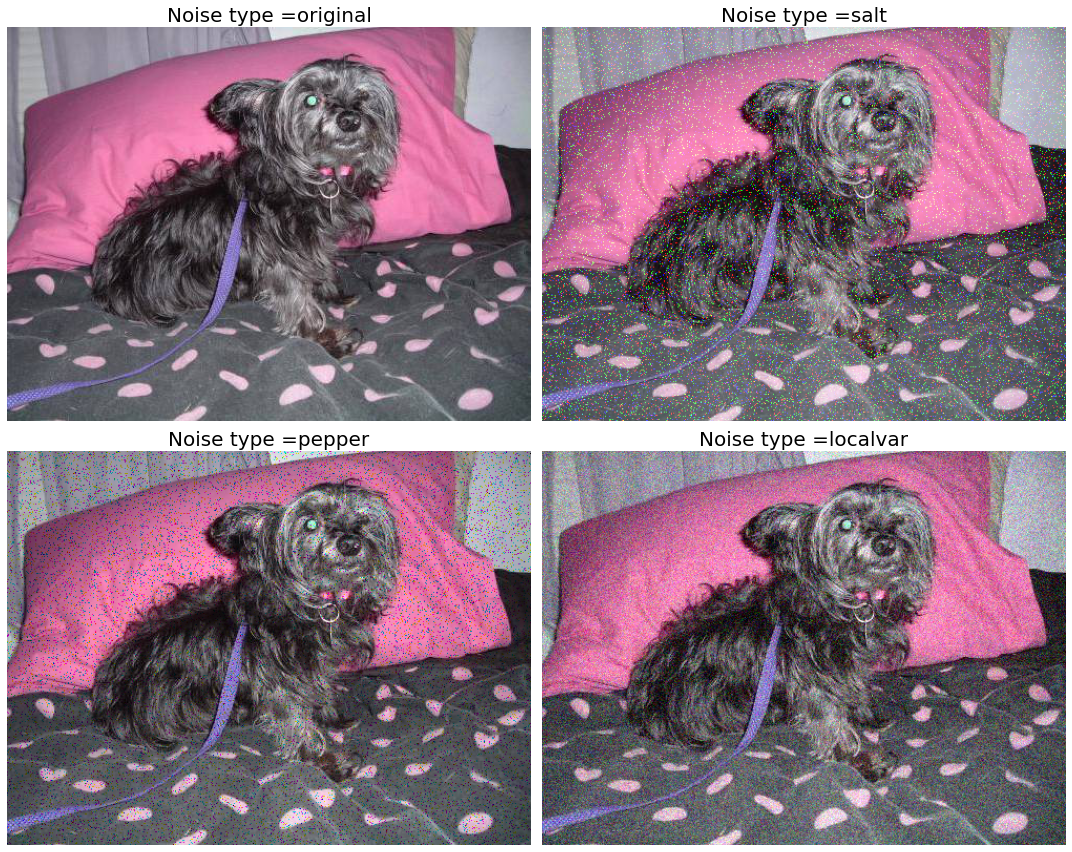

In [5]:


im = img_as_float(imread("/tmp/cats_and_dogs_filtered/train/dogs/dog.0.jpg"))
plt.figure(figsize=(15,12))
sigmas = ['original','salt','pepper','localvar']
for i in range(4): 
  if(i == 0):
    plt.subplot(2,2,i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title('Noise type =' + str(sigmas[i]), size=20)
  else:
    noisy = random_noise(im,mode = sigmas[i])
    plt.subplot(2,2,i+1)
    plt.imshow(noisy)
    plt.axis('off')
    plt.title('Noise type =' + str(sigmas[i]), size=20)
plt.tight_layout()
plt.savefig('examples.png')
plt.show()


In [6]:

def noise1(img):
  #print("noise X shape",img.shape)
  temp = random_noise(img, mode = 'pepper')
  return temp
def noise2(img):
  temp = random_noise(img, mode = 'salt')
  return temp
def noise3(img):
  temp = random_noise(img, mode = 'localvar')
  return temp

def noise4(img):
  return img

def allign(inputs):
  dictionary = {1:noise1,2:noise2,3:noise3,4:noise4}#,5:noise5}
  img,ran = inputs
  ret = dictionary[ran](img)
  
  return ret



def preprocessing(x,batch_size):
  temp = []
  z=0
  #print("preprocessing X shape",x.shape)
  ran = np.random.choice(np.arange(1, 5),batch_size)
  
  temp = list(map(allign,zip(x,ran)))
  
  temp = np.array(temp)   
  
  
  return temp

# Preprocessing Generator

In [7]:


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dir, batch_size=32, dim=(512, 512,3), n_channels=1,
                  shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        train_datagen_X = ImageDataGenerator(rescale=1./255)     # for X
        self.train_generator_X = train_datagen_X.flow_from_directory(dir,  target_size=dim[:2], 
                                                                 batch_size=batch_size,class_mode= "categorical") 

        #train_datagen_y = ImageDataGenerator(rescale=1./255)     # for y
        #self.train_generator_y = train_datagen_y.flow_from_directory(dir,  target_size=dim[:2], batch_size=batch_size,class_mode= "categorical")

        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.train_generator_X)

    def __getitem__(self,a=0):
        'Generate one batch of data'
        # Generate data
        X,y = self.__data_generation()
        #print("get item X shape",X.shape) 
        return X,y

    def __data_generation(self):
        'Generates data containing batch_size samples'
        
        
        X,_ = next(self.train_generator_X)
        y = X
        #print("data_gen X shape",X.shape)
        X = preprocessing(X,self.batch_size)

        return X,y

In [8]:
training_generator = DataGenerator(train_dir)
validation_generator = DataGenerator(validation_dir)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# HELPER FUNCTION

In [9]:

def plotter(history,place):
  
  plt.figure(figsize = (16,16))
  
  hist = history.history
  keys = list(history.history.keys())
  print(keys)

  for i in range(0,len(keys)):
    plt.subplot(4,4,i+1)
    keys[i]
    plt.plot(hist[keys[i]])
    plt.title(keys[i])
  
  
  plt.savefig(place + 'losses.png')

  plt.tight_layout()
  plt.show()


In [19]:



def example(a,b,pro,place):
  plt.figure(figsize=(15,45))
  for i in range(1,10): 
    plt.subplot(9,3,3*i-2)
    plt.imshow(a[i])
    plt.title('noised', size=10)
    plt.axis('off')
    plt.subplot(9,3,3*i-1)
    plt.imshow(b[i])
    plt.title('original', size=10)
    plt.axis('off')
    plt.subplot(9,3,3*i)
    plt.imshow(pro[i])
    plt.title('restored', size=10)
    plt.axis('off')
    plt.savefig(place + 'examples.png')
  plt.tight_layout()
  plt.show()



In [10]:
def ssim(img1,img2):
  return 1 - tf.image.ssim(img1,img2,max_val=2)


In [11]:
def psnr(im1,im2):
    max_pixel = 1.0
    return 100 - tf.image.psnr(im1, im2, max_val=1)

In [12]:
from keras.losses import mean_squared_error
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [13]:
def THEMAINFUNCTION(model,losses,epochs = 20):
  
  date_time=str(datetime.datetime.now())
  date_time=date_time.replace(' ','_')
  date_time=date_time.replace(':','-')
  date_time=date_time.replace('.','-')
  print(date_time)
  os.makedirs(date_time)
  tf.keras.utils.plot_model(model,to_file=date_time+'/'+'model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)
  
  main_history = []
  model.save_weights('my_model_weights.h5')
  for x in losses:
    model.load_weights('my_model_weights.h5')
    training_generator = DataGenerator(train_dir)
    validation_generator = DataGenerator(validation_dir)
    
    y = x
    if(x == root_mean_squared_error):
      y = 'root_mean_squared_error'
    if(x == psnr):
      y = 'psnr'
    if(x == ssim):
      y = 'ssim'
    os.makedirs(date_time+'/'+y)
    print("\n"+y+'\n')


    
    model.compile(loss=x,
              optimizer='adam',
              metrics=losses+[psnr,ssim],
              )
    

    history = model.fit(
      training_generator,
      validation_data = validation_generator,
      epochs=epochs,  # 1000 images = batch_size * steps
      )
    
    plotter(history,date_time+'/'+y+'/')

    a,b = validation_generator.__getitem__()
    pro = model.predict(a)

    example(a,b,pro,date_time+'/'+y+'/')
    final_losses = { x:y[-1] for x,y in history.history.items() }
    main_history.append(final_losses)
    print(final_losses)
  df = pd.DataFrame(main_history)
  df.index = losses
  df.to_csv(date_time+'/'+'loss_table.csv')
  return main_history


#models

In [ ]:
training_generator = DataGenerator(train_dir)
validation_generator = DataGenerator(validation_dir)

#######Add Your Model below#########




#######Add your Model Above##########



model.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=[psnr,ssim,'mae'],
              )




#Implementation

In [ ]:
losses = ['mean_absolute_error',"mean_squared_error","mean_squared_logarithmic_error","binary_crossentropy",root_mean_squared_error]
data = THEMAINFUNCTION(model,losses,epochs = 20)  

In [ ]:
!zip -r ./model1.zip /content/#TIME STAMP FOLDER